In [1]:
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from tqdm.keras import TqdmCallback
sys.path.append("../../../")
from src.Evaluation import plot_model_history
from src.ModelBuilder import get_MLP, get_MCDCNN, get_Time_CNN, get_FCN, get_Encoder
from src.LoadData import get_all_datasets_test_train_np_arrays
from src.Helpers import append_to_csv

2023-01-18 17:54:44.196996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 17:54:44.326434: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-18 17:54:45.194439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-01-18 17:54:45.194516: W tensorflow/compil

In [ ]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/opt/bwhpc/common/devel/cuda/11.8

In [2]:
path_to_datasets = "../../../datasets"

In [3]:
datasets_test_train_data = get_all_datasets_test_train_np_arrays(path_to_datasets)

In [4]:
models_getter = [get_MLP, ]
models_names = ["MLP", ]

In [5]:
# tf.debugging.set_log_device_placement(True)
devices = tf.config.list_logical_devices('GPU') # Use this to run training just on GPUs
#devices = tf.config.list_logical_devices()
strategy = tf.distribute.MirroredStrategy(devices)

2023-01-18 17:54:55.233968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 17:54:56.398005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30952 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2023-01-18 17:54:56.398802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30952 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [6]:
devices

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [7]:
path_persist_results = "./training_res.csv"
if not (csv_path := Path(path_persist_results)).exists():
    csv_path.touch()
if len(csv_path.read_text()) == 0:
    # Only write if the file is empty
    columns = ["dataset_name", "model_name", "test_loss", "test_acc", "confusion_matrix", "history"]
    append_to_csv(path_persist_results, columns)

In [8]:
epochs = 30
batch_size = 10
validation_split = 0.2

In [9]:
with strategy.scope():
    for ds_name, ds_data in tqdm(datasets_test_train_data.items(), unit='dataset'):
        print("Dataset name: ", ds_name)
        x_test, y_test = ds_data["test_data"]
        x_train, y_train = ds_data["train_data"]

        input_size = x_train.shape[1]
        output_size = len(np.unique(y_train))

        for get_model, model_name in tqdm(list(zip(models_getter, models_names)), unit='model', desc=f'Train on "{ds_name}"'):
            print("Model name: ", model_name)
            model = get_model(input_size, output_size)
            model.compile(optimizer='SGD',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[TqdmCallback(verbose=0, desc=model_name)], verbose=0)
            test_loss, test_acc = model.evaluate(x_test, y_test)
            # TODO: add confusion matrix

            row = [ds_name,
                  model_name,
                  test_loss,
                  test_acc,
                  None, # TODO: persist confusion matrix to further analysis
                  json.dumps(history.history)]
            append_to_csv(path_persist_results, row)

  0%|          | 0/11 [00:00<?, ?dataset/s]

Dataset name:  abnormal_heartbeat


Train on "abnormal_heartbeat":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


MLP: 0epoch [00:00, ?epoch/s]

INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

2023-01-18 17:55:01.745315: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559cf123d600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-18 17:55:01.745352: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-01-18 17:55:01.745357: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-01-18 17:55:01.798811: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 0s 3ms/step - loss: 0.7799 - accuracy: 0.7317
Dataset name:  phalanges_outlines_correct


Train on "phalanges_outlines_correct":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
27/27 [==============================] - 1s 2ms/step - loss: 0.6375 - accuracy: 0.6434
Dataset name:  swedish_leaf


Train on "swedish_leaf":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
20/20 [==============================] - 1s 2ms/step - loss: 0.6988 - accuracy: 0.7840
Dataset name:  share_price_increase


Train on "share_price_increase":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
31/31 [==============================] - 0s 2ms/step - loss: 1.1688 - accuracy: 0.7019
Dataset name:  distal_phalanx_outline


Train on "distal_phalanx_outline":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
9/9 [==============================] - 1s 3ms/step - loss: 0.5603 - accuracy: 0.7391
Dataset name:  electric_devices


Train on "electric_devices":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

241/241 [==============================] - 1s 2ms/step - loss: 1.8956 - accuracy: 0.5860
Dataset name:  freezers


Train on "freezers":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

90/90 [==============================] - 2s 2ms/step - loss: 0.5393 - accuracy: 0.8095
Dataset name:  cricket_y


Train on "cricket_y":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

13/13 [==============================] - 0s 2ms/step - loss: 1.4732 - accuracy: 0.5333
Dataset name:  coffee_beans


Train on "coffee_beans":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

1/1 [==============================] - 0s 113ms/step - loss: 0.7610 - accuracy: 0.5357
Dataset name:  arrow_head


Train on "arrow_head":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

6/6 [==============================] - 0s 3ms/step - loss: 0.8519 - accuracy: 0.6000
Dataset name:  wafer


Train on "wafer":   0%|          | 0/1 [00:00<?, ?model/s]

Model name:  MLP


MLP: 0epoch [00:00, ?epoch/s]

193/193 [==============================] - 2s 2ms/step - loss: 0.0272 - accuracy: 0.9919


# Example load training results and display evaluation results

In [10]:
df_training_res = pd.read_csv(path_persist_results)

In [11]:
df_training_res

,dataset_name,model_name,test_loss,test_acc,confusion_matrix,history
0,abnormal_heartbeat,MLP,0.779899,0.731707,NaN,"{""loss"": [0.6390953660011292, 0.54119127988815..."
1,phalanges_outlines_correct,MLP,0.637458,0.643357,NaN,"{""loss"": [0.6679225564002991, 0.64569669961929..."
2,swedish_leaf,MLP,0.698804,0.784000,NaN,"{""loss"": [2.653488874435425, 2.433038234710693..."
3,share_price_increase,MLP,1.168756,0.701863,NaN,"{""loss"": [0.4914316236972809, 0.44991609454154..."
4,distal_phalanx_outline,MLP,0.560262,0.739130,NaN,"{""loss"": [0.6983198523521423, 0.69319468736648..."
5,electric_devices,MLP,1.895621,0.586046,NaN,"{""loss"": [1.532529354095459, 1.288466930389404..."
6,freezers,MLP,0.539330,0.809474,NaN,"{""loss"": [0.6914803981781006, 0.59172272682189..."
7,cricket_y,MLP,1.473178,0.533333,NaN,"{""loss"": [2.543464183807373, 2.228128671646118..."
8,coffee_beans,MLP,0.760960,0.535714,NaN,"{""loss"": [0.6985465884208679, 0.80913585424423..."
9,arrow_head,MLP,0.851944,0.600000,NaN,"{""loss"": [1.0495268106460571, 1.13665223121643..."


In [12]:
history = df_training_res['history'][0]

Highest Validation Accuracy: 0.0


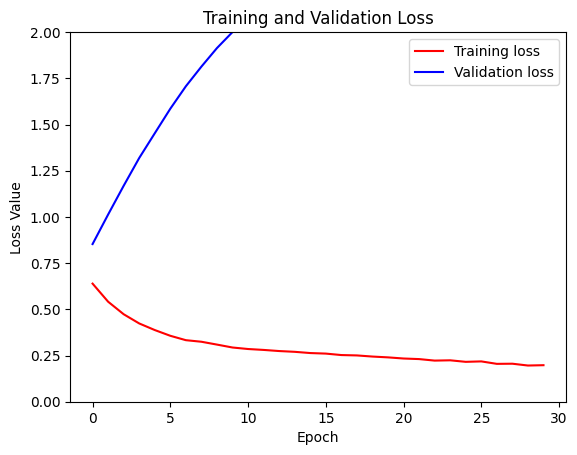

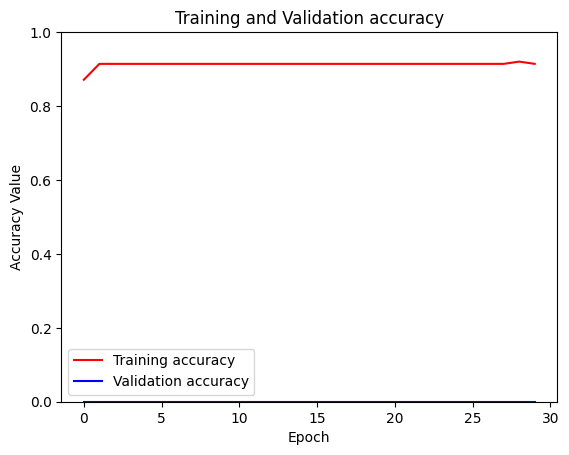

In [13]:
plot_model_history(json.loads(history), epochs=epochs)